## Cost Sensitive Customer Churn Prediction
Churn prediction is a business problem where a company wants to predict whether a customer under some kind of renewable contract, such as a mobile cell phone plan, will stay with the company or leave (churn). Companies want to know whether or not a customer is likely to churn to help the company decide what, if any, action it should take with the customer. However, this is more than a regular machine learning classification problem; this is a business problem, with marketing costs and customer lifetime value involved. Therefore, the goal of this model is not to maximize F1 Score or minimize cross entropy loss explicitly, but rather to ***minimize overall costs***. Although it involves classification, at heart this is really a cost optimization problem.

In [1]:
import pandas as pd

data = pd.read_csv('iranian_churn.csv')

In [2]:
print(data.shape)
data.head()

(3150, 16)


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,177.8760,69.7640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,216.0180,74.0020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,131.2245,64.5805,0


The dataset contains a number of potential predictor variables as well as the costs of False Positives and False Negatives for each instance. This is what will allow me to perform cost-sensitive learning. The target class is the binary variable "Churn".

### Exploratory data analysis

In [3]:
data['Churn'].value_counts()

0    2655
1     495
Name: Churn, dtype: int64

This dataset has a class imbalance, with many more instances of customers not churning than churning. I will be sure to use stratified sampling when I split my data into train, validation, and test sets to maintain a representation of this balance.

In [4]:
data.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,423.875624,98.304688,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,465.313890,50.724492,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000,60.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,102.421125,61.380125,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,205.632000,72.848000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,709.549875,128.838875,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1948.752000,266.528000,1.000000


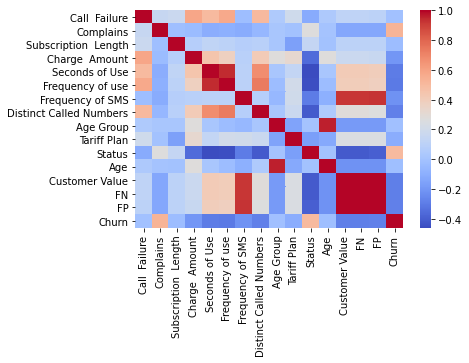

In [5]:
# Visualize the correlations among features
import seaborn as sns

sns.heatmap(data.corr(), cmap='coolwarm')

In [6]:
# Shows which features are most correlated with Churn
data.corr()['Churn'].sort_values(ascending=False)

Churn                      1.000000
Complains                  0.532053
Status                     0.498976
Call  Failure             -0.008987
Age Group                 -0.014550
Age                       -0.017705
Subscription  Length      -0.032588
Tariff Plan               -0.105853
Charge  Amount            -0.202305
Frequency of SMS          -0.220754
FP                        -0.278057
Distinct Called Numbers   -0.278867
Customer Value            -0.289144
FN                        -0.289144
Seconds of Use            -0.298935
Frequency of use          -0.303337
Name: Churn, dtype: float64

"Complains" and "Status" are the features most positively correlated with Churn.

--------------------------

## Data Preparation

The repository where I found this dataset had a description for some of the columns but not for all of them. Therefore, I must get more info about these features and see if there are any categorical variables that need to be encoded as numbers. 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  FN                       3150 non-null   float64
 14  FP                      

In [8]:
# Print out the number of unique values for each feature 
for feature in data.columns.tolist():
    print(feature)
    print(data[feature].nunique())
    print('\n')

Call  Failure
37


Complains
2


Subscription  Length
45


Charge  Amount
11


Seconds of Use
1756


Frequency of use
242


Frequency of SMS
405


Distinct Called Numbers
92


Age Group
5


Tariff Plan
2


Status
2


Age
5


Customer Value
2654


FN
2654


FP
2195


Churn
2




Now I will inspect the featues that had a small number of unique values, as these features are likely categorical variables.

In [9]:
# Complains appears to be a binary variable ==> no further encoding is needed
data['Complains'].value_counts()

0    2909
1     241
Name: Complains, dtype: int64

In [10]:
# Check 'Charge Amount' because it has relatively few unique values
data['Charge  Amount'].value_counts()

0     1768
1      617
2      395
3      199
4       76
5       30
8       19
9       14
7       14
6       11
10       7
Name: Charge  Amount, dtype: int64

'Charge Amount' is indeed a categorical variable, but it has a natural ordinal encoding so it doesn't need any further encoding.

In [11]:
# Age Group
data['Age Group'].value_counts()

3    1425
2    1037
4     395
5     170
1     123
Name: Age Group, dtype: int64

'Age Group' is a categorical variable as well, but according to the description of the dataset's columns, these categories have an ordinal pattern so no further encoding is needed.

In [12]:
# Tariff Plan
data['Tariff Plan'].value_counts()

1    2905
2     245
Name: Tariff Plan, dtype: int64

'Tariff Plan' is also a categorical variable, but it does not have an ordinal encoding and is not currently formatted as a binary variable. There are only two categories, but they are not encoded as 0 and 1. I will encode this feature below by changing category 1 to 0 and category 2 to 1.

In [13]:
data['Tariff Plan'] = data['Tariff Plan'].apply(lambda x: x - 1 )

In [14]:
data['Tariff Plan'].head()

0    0
1    0
2    0
3    0
4    0
Name: Tariff Plan, dtype: int64

In [15]:
# Status
data['Status'].value_counts()

1    2368
2     782
Name: Status, dtype: int64

In [16]:
# Status also needs to be re-encoded to 0s and 1s
data['Status'] = data['Status'].apply(lambda x: x - 1 )

In [17]:
data['Status'].head()

0    0
1    1
2    0
3    0
4    0
Name: Status, dtype: int64

In [18]:
# Age
data['Age'].value_counts()

30    1425
25    1037
45     395
55     170
15     123
Name: Age, dtype: int64

'Age' is already represented in 'Age Group', so I will drop this redundant feature.

In [19]:
data.drop('Age', axis=1, inplace=True)

In [20]:
data.shape

(3150, 15)

In [21]:
data.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Customer Value,FN,FP,Churn
0,8,0,38,0,4370,71,5,17,3,0,0,197.640,177.8760,69.7640,0
1,0,0,39,0,318,5,7,4,2,0,1,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60,359,24,3,0,0,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66,1,35,1,0,0,240.020,216.0180,74.0020,0
4,3,0,38,0,2393,58,2,33,1,0,0,145.805,131.2245,64.5805,0


### Split the data into train, validation, and test sets

In [24]:
# Drop the labels from the input data and select 'Churn' for the labels

X = data.drop(['Churn'], axis=1)
y = data['Churn']

In [25]:
print(X.shape)
print(y.shape)

(3150, 14)
(3150,)


In [26]:
from sklearn.model_selection import train_test_split

# Set the 'stratify' parameter so the class balance is preserved
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                      test_size=0.15, stratify=y_train_full, random_state=42)

In [27]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(2275, 14)
(402, 14)
(473, 14)
(2275,)
(402,)
(473,)


Below I will select and remove the FN and FP columns from each of the datasets so they can be used to calculate misclassification costs later and will not be predictors directly.

In [29]:
train_misclassification_costs_df = X_train[['FN', 'FP']]
valid_misclassification_cost_df = X_valid[['FN', 'FP']]
test_misclassification_cost_df = X_test[['FN', 'FP']]

# Drop the columns from each dataset
X_train.drop(['FN', 'FP'], axis=1, inplace=True)
X_valid.drop(['FN', 'FP'], axis=1, inplace=True)
X_test.drop(['FN', 'FP'], axis=1, inplace=True)

/Users/PayPay/ml/my_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(2275, 12)
(402, 12)
(473, 12)


In [31]:
print(y_train.value_counts() / len(y_train))
print(y_valid.value_counts() / len(y_valid))
print(y_test.value_counts() / len(y_test))

0    0.842637
1    0.157363
Name: Churn, dtype: float64
0    0.843284
1    0.156716
Name: Churn, dtype: float64
0    0.843552
1    0.156448
Name: Churn, dtype: float64


The data has been split into train, validation, and test sets, and the class balance of churn vs. no churn has been maintained across these datasets.

### Scale the input features.

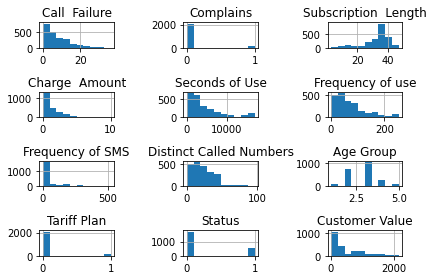

In [32]:
import matplotlib.pyplot as plt

X_train.hist()
plt.tight_layout()
plt.show()

Because the input variables are not normally distributed, I will use MinMaxScaler to normalize the data rather than StandardScaler.

In [33]:
# Scale the input features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train) # fit the scaler on the training set and transform it

# Transform, but do not fit, the validation and test sets
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

-------

## Build the Model

### First a note on the cost-sensitive learning approach and the evaluation metric.
This dataset includes the economic cost in dollars of misclassifying instances. This allows me to perform cost-sensitive learning. The dataset doesn't make it clear how these costs are calculated, but in a real business scenario, I would hopefully have access to more context or people who could explain these costs. Regardless of their provenance, I will use these costs in my model. There are two approaches I can take to incorporate these misclassification costs:

1) I can create a custom loss function that incorporates the cost of false positives and false negatives directly. So during training, the binary crossentropy loss function being optimized will know not to punish false positives and false negatives equally, but rather according to their actual costs. When the model spits out a prediction, it will have already considered to costs of false negatives and false positives.

2) I can leave the loss function alone and have the model predict class probabilities. Then I can create a custom function that uses these probabilities and the costs of false positives and false negatives to calculate an expected cost value for predicting Churn and an expected cost value for predicting No Churn. Then this function can simply select the prediction with the lowest expected cost to be the model's final prediction.

These adjustments above mean that traditional classification evaluation metrics such as the F1 score will not suffice as the most relevant measure of performance. Instead, the model needs an evaluation metric that will incorporate the costs of False Positives and False Negatives. Therefore, I will create a custom metric that captures ***Cost Savings***.

To calculate this metric, I will first calculate a baseline cost by determining what the cost would be if the company randomly guessed which customers would churn. Then I will use the trained model to make predictions and calculate the misclassification costs of these predictions. Finally, I will be able to compare the model's cost to the random guessing scenario's cost and determine the cost savings. So I want the *Cost Savings* (baseline cost - model's cost) to be as high as possible.

One final note, the dataset includes costs for false positives and false negatives but not for true positives and true negatives. Realistically, in a churn problem like this a true positive likely would not have a cost of $ 0 because usually the company would send this likely-churning customer some marketing materials or conduct some kind of outreach. For now though, I will keep the true positive cost at 0 dollars, but I will create a variable to represent the cost of a true positive so it can be changed easily if needed.

Now, on to model building!

### I will build the second model described above, using the expected cost as a decision heuristic at the end of the model rather than creating a custom loss function. Below are the functions needed to build this second model as well as the custom evaluation metric.

In [34]:
import numpy as np

In [35]:
# True positive and true negative cost variables
tp_cost = 0
tn_cost = 0

In [412]:
# This is the final prediction layer that uses the expected value of costs to make its final predictions
def expected_value_prediction(model, input_data, misclassification_df):
    """
    This function takes a trained model and
    input_data to make predictions on as well as a
    misclassification costs dataframe.
    The model will predict class probabilities
    and the function will compute expected values using
    these probabilities and the misclassification cost data.
    This function will return a numpy array of class predictions.
    """
    y_probas = model.predict(input_data) # get the predicted probability of Churn for each instance
    class_predictions = []
    
    # Iterate through all the predicted probabilities, calculate expected values and classify each instance as
    # either 0 or 1 depending on which expected cost value was lower. Append each prediction to the list.
    for index, churn_proba in enumerate(y_probas.reshape(input_data.shape[0])): # reshape y_probas as a 1D array
        # expected_cost_churn is the expected cost of predicting churn
        expected_cost_churn = (tp_cost * churn_proba) + (misclassification_df['FP'].iloc[index] * (1 - churn_proba))
        # expected_cost_no_churn is the expected cost of predicting no churn
        expected_cost_no_churn = (tn_cost * (1 - churn_proba)) + (misclassification_df['FN'].iloc[index] * churn_proba)

        if expected_cost_churn < expected_cost_no_churn:
            prediction = 1
        else:
            prediction = 0
            
        class_predictions.append(prediction)
        
    return np.array(class_predictions)

In [37]:
def prediction_term(actual, predicted):
    """
    Function takes the actual and predicted class value
    of an instance and returns a string signifying
    whether the instance is a true positive, true negative
    false positive or false negative.
    """
    tup = (actual, predicted)
    if tup == (0, 0):
        return 'TN'
    elif tup == (0, 1):
        return 'FP'
    elif tup == (1, 0):
        return 'FN'
    elif tup == (1, 1):
        return 'TP'

In [38]:
def calculate_cost(true_labels, predictions, misclassification_df):
    """
    Function takes true labels, predictions, and the
    misclassification dataframe containing the
    false negative and false positive costs as input.
    Then it classifies predictions as either
    TP, TN, FP, FN and sums up the respective costs.
    Returns a the total cost of these predictions
    as a float.
    """
    total_cost = 0
    for index, value in enumerate(predictions):
        term = prediction_term(true_labels[index], value)
        if term == 'FN' or term == 'FP':
            total_cost += misclassification_df[term].iloc[index]
        elif term == 'TP':
            total_cost += tp_cost
        elif term == 'TN':
            total_cost += tn_cost
    return total_cost

In [39]:
# Below is the custom evaluation function
def evaluate_cost_savings(model, misclassification_costs_df, input_data, true_labels):
    """
    This function calculates the Cost Savings metric.
    It takes a trained model, a misclassification costs dataframe,
    input data, and the true class labels as input.
    Then it calculates the baseline cost under the random guessing
    scenario and the cost obtained by the cost sensitive trained model.
    Returns the difference between baseline cost and model's cost
    as a number in dollars. Larger values indicate a better model.
    """
    # Convert the Labels pandas Series to a list
    true_labels = true_labels.to_numpy()
    
    # Calculate the baseline cost of random guessing
    
    # Randomly generate an array of 0s and 1s with a length the size of the labels, then calculate the cost
    np.random.seed(42)
    random_guess_classes = np.random.randint(2, size=len(true_labels))
    random_cost = calculate_cost(true_labels, random_guess_classes, misclassification_costs_df)
    
    # Calculate the trained cost sensitive model's cost
    
    # Get the predicted class based on the expected cost values
    y_prediction_classes = expected_value_prediction(model, input_data, misclassification_costs_df)
    model_cost = calculate_cost(true_labels, y_prediction_classes, misclassification_costs_df)
    
    # Calculate cost savings
    cost_savings = random_cost - model_cost
    
    print("Random Guess Baseline Cost: $" + str(round(random_cost, 2)))
    print("Model Cost: $" + str(round(model_cost, 2)))
    print("Cost Savings: $" + str(round(cost_savings, 2)))
    print('\n')
    return cost_savings

### Automatically test for the ideal hyperparameters

#### I had planned on using GridSearch to automatically search for the best set of hyperparameters. However, this required me to create a function that returned a Keras model, wrap this model in a Scikit Learn wrapper, and create a custom scorer based on my Cost Savings evaluation metric, all to put my model in a format that the standard GridSearch could use. Instead of changing my current setup to fit GridSearch's setup, why not just create a custom GridSearch that already fits my current setup? This is done below.

In [40]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
K = keras.backend

First make a function that creates a model given some hyperparameters.

In [41]:
def create_model(weight_initialization, activation, dropout_rate):
    """
    Function takes hyperparameter arguments and creates a
    Keras model using these hyperparameters.
    Returns a model ready for compilation and training.
    """
    model = keras.models.Sequential([
        layers.Dense(48, input_dim=X_train_scaled.shape[1], kernel_initializer=weight_initialization, 
                     activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(36, kernel_initializer=weight_initialization, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(28, kernel_initializer=weight_initialization, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(20, kernel_initializer=weight_initialization, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(14, kernel_initializer=weight_initialization, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(8, kernel_initializer=weight_initialization, activation=activation),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

Next define a set of hyperparameters to test in the grid search.

In [42]:
# I will give each layer the same initialization rather than vary the initializations across the layers
weight_initializations = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 
                         'he_normal', 'he_uniform']

# These activations will only apply to the hidden layers; the output's activation must be sigmoid for this problem
activation_functions = ['relu', 'selu', 'elu']

# Dropout rates
dropout_rates = [0.2, 0.5, 0.8]

I could also search for the ideal number of neurons and layers, but I will keep those constant and only adjust the variables above. The combination of these parameters results in 72 different models that will be built, trained, and tested.

Next, create a custom grid search function.

In [414]:
def run_grid_search(weight_initializations, activation_functions, dropout_rates):
    """
    Function takes lists of hyperparameters to test,
    builds many models with an exhaustive combination
    of the hyperparameters, evaluates the models using
    the cost savings metric, and stores the model parameter
    configurations and scores in a list that it returns.
    """
    
    # Keep a list of dicts containing model parameters and their scores. This list will be sorted by cost_savings 
    # score to determine the best performing configuration.
    model_scores_params = []
    
    for weight in weight_initializations:
        for activation in activation_functions:
            for rate in dropout_rates:
                model = create_model(weight, activation, rate)
                model.compile(loss='binary_crossentropy', optimizer='adam')
                model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), verbose=0)
                
                # Evaluate the cost savings metric on the validation data
                cost_savings = evaluate_cost_savings(model, valid_misclassification_cost_df, X_valid_scaled, y_valid)
                # Store the results from this iteration
                model_scores_params.append({'weight_initialization': weight, 'activation': activation,
                                            'dropout_rate': rate, 'cost_savings': cost_savings})   
    
    return model_scores_params

#### Finally, run the grid search!

In [470]:
# Clear backend and set random seed
K.clear_session()

from tensorflow.random import set_seed
set_seed(42)

In [45]:
# I want to see how long the grid search takes, so I will keep track of the time elapsed
import time

In [46]:
start = time.time()
grid_search_results = run_grid_search(weight_initializations, activation_functions, dropout_rates)
end = time.time()

Random Guess Baseline Cost: $19037.97
Model Cost: $1313.61
Cost Savings: $17724.36


Random Guess Baseline Cost: $19037.97
Model Cost: $2075.71
Cost Savings: $16962.25


Random Guess Baseline Cost: $19037.97
Model Cost: $4436.28
Cost Savings: $14601.69


Random Guess Baseline Cost: $19037.97
Model Cost: $2648.32
Cost Savings: $16389.65


Random Guess Baseline Cost: $19037.97
Model Cost: $2904.99
Cost Savings: $16132.98


Random Guess Baseline Cost: $19037.97
Model Cost: $2907.24
Cost Savings: $16130.73


Random Guess Baseline Cost: $19037.97
Model Cost: $3186.42
Cost Savings: $15851.55


Random Guess Baseline Cost: $19037.97
Model Cost: $3024.99
Cost Savings: $16012.98


Random Guess Baseline Cost: $19037.97
Model Cost: $3177.75
Cost Savings: $15860.22


Random Guess Baseline Cost: $19037.97
Model Cost: $1168.08
Cost Savings: $17869.89


Random Guess Baseline Cost: $19037.97
Model Cost: $1883.17
Cost Savings: $17154.8


Random Guess Baseline Cost: $19037.97
Model Cost: $4131.19
Cost Sa

In [56]:
print((end - start) / 60, 'minutes')

51.16714281638463 minutes


In [57]:
sorted_results = sorted(grid_search_results, key=lambda k: k['cost_savings'], reverse=True)
best_model = sorted_results[0]
best_model

{'weight_initialization': 'lecun_uniform',
 'activation': 'relu',
 'dropout_rate': 0.2,
 'cost_savings': 17869.887500000004}

The grid search found the above hyperparameters to be the ones that maximized cost savings.

### I will now create a fresh model with these optimal hyperparameters and train the model for a greater number of epochs.

In [486]:
weight_initialization = best_model['weight_initialization']
activation = best_model['activation']
dropout_rate = best_model['dropout_rate']

model = keras.models.Sequential([
    layers.Dense(48, input_dim=X_train_scaled.shape[1], kernel_initializer=weight_initialization, 
                 activation=activation),
    layers.Dropout(dropout_rate),
    layers.Dense(36, kernel_initializer=weight_initialization, activation=activation),
    layers.Dropout(dropout_rate),
    layers.Dense(28, kernel_initializer=weight_initialization, activation=activation),
    layers.Dropout(dropout_rate),
    layers.Dense(20, kernel_initializer=weight_initialization, activation=activation),
    layers.Dropout(dropout_rate),
    layers.Dense(14, kernel_initializer=weight_initialization, activation=activation),
    layers.Dropout(dropout_rate),
    layers.Dense(8, kernel_initializer=weight_initialization, activation=activation),
    layers.Dense(1, activation='sigmoid')
])

In [487]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

In [488]:
set_seed(42)
# Fit the model
history = model.fit(X_train_scaled, y_train, epochs=500, validation_data=(X_valid_scaled, y_valid))

Epoch 1/500
72/72 [==============================] - 1s 8ms/step - loss: 0.5280 - accuracy: 0.8215 - auc_2: 0.5226 - val_loss: 0.3489 - val_accuracy: 0.8433 - val_auc_2: 0.8762
Epoch 2/500
72/72 [==============================] - 0s 3ms/step - loss: 0.3212 - accuracy: 0.8426 - auc_2: 0.8531 - val_loss: 0.2693 - val_accuracy: 0.8433 - val_auc_2: 0.9050
Epoch 3/500
72/72 [==============================] - 0s 3ms/step - loss: 0.2859 - accuracy: 0.8426 - auc_2: 0.8809 - val_loss: 0.2607 - val_accuracy: 0.8433 - val_auc_2: 0.9117
Epoch 4/500
72/72 [==============================] - 0s 3ms/step - loss: 0.2765 - accuracy: 0.8426 - auc_2: 0.8816 - val_loss: 0.2534 - val_accuracy: 0.8433 - val_auc_2: 0.8998
Epoch 5/500
72/72 [==============================] - 0s 4ms/step - loss: 0.2712 - accuracy: 0.8448 - auc_2: 0.8992 - val_loss: 0.2524 - val_accuracy: 0.8433 - val_auc_2: 0.9235
Epoch 6/500
72/72 [==============================] - 0s 4ms/step - loss: 0.2745 - accuracy: 0.8475 - auc_2: 0.8934 

72/72 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.9468 - auc_2: 0.9829 - val_loss: 0.1094 - val_accuracy: 0.9502 - val_auc_2: 0.9795
Epoch 94/500
72/72 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9429 - auc_2: 0.9798 - val_loss: 0.1131 - val_accuracy: 0.9577 - val_auc_2: 0.9851
Epoch 95/500
72/72 [==============================] - 0s 3ms/step - loss: 0.1124 - accuracy: 0.9574 - auc_2: 0.9837 - val_loss: 0.1104 - val_accuracy: 0.9502 - val_auc_2: 0.9839
Epoch 96/500
72/72 [==============================] - 0s 3ms/step - loss: 0.1178 - accuracy: 0.9547 - auc_2: 0.9818 - val_loss: 0.1099 - val_accuracy: 0.9602 - val_auc_2: 0.9843
Epoch 97/500
72/72 [==============================] - 0s 2ms/step - loss: 0.1205 - accuracy: 0.9508 - auc_2: 0.9809 - val_loss: 0.1021 - val_accuracy: 0.9701 - val_auc_2: 0.9858
Epoch 98/500
72/72 [==============================] - 0s 3ms/step - loss: 0.1244 - accuracy: 0.9420 - auc_2: 0.9814 - val_l

Epoch 184/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0867 - accuracy: 0.9635 - auc_2: 0.9900 - val_loss: 0.0920 - val_accuracy: 0.9677 - val_auc_2: 0.9884
Epoch 185/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0821 - accuracy: 0.9653 - auc_2: 0.9919 - val_loss: 0.0933 - val_accuracy: 0.9677 - val_auc_2: 0.9877
Epoch 186/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0822 - accuracy: 0.9657 - auc_2: 0.9909 - val_loss: 0.0918 - val_accuracy: 0.9677 - val_auc_2: 0.9872
Epoch 187/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0947 - accuracy: 0.9591 - auc_2: 0.9869 - val_loss: 0.0900 - val_accuracy: 0.9701 - val_auc_2: 0.9893
Epoch 188/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0861 - accuracy: 0.9679 - auc_2: 0.9901 - val_loss: 0.0915 - val_accuracy: 0.9652 - val_auc_2: 0.9869
Epoch 189/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0830 - accuracy: 0.9618 - au

Epoch 230/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0873 - accuracy: 0.9591 - auc_2: 0.9907 - val_loss: 0.0958 - val_accuracy: 0.9726 - val_auc_2: 0.9872
Epoch 231/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9675 - auc_2: 0.9928 - val_loss: 0.0902 - val_accuracy: 0.9652 - val_auc_2: 0.9899
Epoch 232/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.9604 - auc_2: 0.9884 - val_loss: 0.0977 - val_accuracy: 0.9652 - val_auc_2: 0.9865
Epoch 233/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0927 - accuracy: 0.9565 - auc_2: 0.9899 - val_loss: 0.0978 - val_accuracy: 0.9677 - val_auc_2: 0.9870
Epoch 234/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0855 - accuracy: 0.9635 - auc_2: 0.9899 - val_loss: 0.1062 - val_accuracy: 0.9652 - val_auc_2: 0.9842
Epoch 235/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0870 - accuracy: 0.9618 - au

Epoch 276/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0761 - accuracy: 0.9675 - auc_2: 0.9912 - val_loss: 0.0906 - val_accuracy: 0.9701 - val_auc_2: 0.9822
Epoch 277/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0747 - accuracy: 0.9710 - auc_2: 0.9927 - val_loss: 0.0910 - val_accuracy: 0.9751 - val_auc_2: 0.9827
Epoch 278/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0798 - accuracy: 0.9635 - auc_2: 0.9923 - val_loss: 0.0906 - val_accuracy: 0.9776 - val_auc_2: 0.9761
Epoch 279/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0902 - accuracy: 0.9662 - auc_2: 0.9878 - val_loss: 0.0971 - val_accuracy: 0.9701 - val_auc_2: 0.9873
Epoch 280/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0816 - accuracy: 0.9626 - auc_2: 0.9917 - val_loss: 0.0971 - val_accuracy: 0.9677 - val_auc_2: 0.9816
Epoch 281/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0750 - accuracy: 0.9666 - au

Epoch 322/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0773 - accuracy: 0.9670 - auc_2: 0.9909 - val_loss: 0.0915 - val_accuracy: 0.9677 - val_auc_2: 0.9871
Epoch 323/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.9670 - auc_2: 0.9941 - val_loss: 0.0963 - val_accuracy: 0.9677 - val_auc_2: 0.9875
Epoch 324/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0769 - accuracy: 0.9640 - auc_2: 0.9928 - val_loss: 0.0946 - val_accuracy: 0.9701 - val_auc_2: 0.9882
Epoch 325/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9692 - auc_2: 0.9948 - val_loss: 0.0922 - val_accuracy: 0.9726 - val_auc_2: 0.9817
Epoch 326/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0668 - accuracy: 0.9697 - auc_2: 0.9947 - val_loss: 0.0891 - val_accuracy: 0.9726 - val_auc_2: 0.9835
Epoch 327/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0809 - accuracy: 0.9684 - au

Epoch 368/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.9653 - auc_2: 0.9940 - val_loss: 0.1027 - val_accuracy: 0.9701 - val_auc_2: 0.9816
Epoch 369/500
72/72 [==============================] - 0s 4ms/step - loss: 0.0776 - accuracy: 0.9697 - auc_2: 0.9927 - val_loss: 0.1022 - val_accuracy: 0.9627 - val_auc_2: 0.9866
Epoch 370/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0751 - accuracy: 0.9631 - auc_2: 0.9931 - val_loss: 0.0972 - val_accuracy: 0.9677 - val_auc_2: 0.9868
Epoch 371/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.9714 - auc_2: 0.9953 - val_loss: 0.0930 - val_accuracy: 0.9701 - val_auc_2: 0.9757
Epoch 372/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9684 - auc_2: 0.9947 - val_loss: 0.0866 - val_accuracy: 0.9726 - val_auc_2: 0.9894
Epoch 373/500
72/72 [==============================] - 0s 3ms/step - loss: 0.0726 - accuracy: 0.9648 - au

Epoch 414/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0720 - accuracy: 0.9675 - auc_2: 0.9926 - val_loss: 0.0950 - val_accuracy: 0.9701 - val_auc_2: 0.9812
Epoch 415/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.9701 - auc_2: 0.9938 - val_loss: 0.0877 - val_accuracy: 0.9701 - val_auc_2: 0.9828
Epoch 416/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0751 - accuracy: 0.9679 - auc_2: 0.9926 - val_loss: 0.0951 - val_accuracy: 0.9677 - val_auc_2: 0.9813
Epoch 417/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9692 - auc_2: 0.9913 - val_loss: 0.0917 - val_accuracy: 0.9701 - val_auc_2: 0.9818
Epoch 418/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.9675 - auc_2: 0.9945 - val_loss: 0.0887 - val_accuracy: 0.9726 - val_auc_2: 0.9887
Epoch 419/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0670 - accuracy: 0.9710 - au

Epoch 460/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9723 - auc_2: 0.9948 - val_loss: 0.0935 - val_accuracy: 0.9776 - val_auc_2: 0.9884
Epoch 461/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.9714 - auc_2: 0.9947 - val_loss: 0.0959 - val_accuracy: 0.9776 - val_auc_2: 0.9823
Epoch 462/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.9732 - auc_2: 0.9938 - val_loss: 0.0842 - val_accuracy: 0.9751 - val_auc_2: 0.9893
Epoch 463/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0746 - accuracy: 0.9662 - auc_2: 0.9935 - val_loss: 0.0951 - val_accuracy: 0.9751 - val_auc_2: 0.9873
Epoch 464/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9723 - auc_2: 0.9954 - val_loss: 0.0957 - val_accuracy: 0.9776 - val_auc_2: 0.9766
Epoch 465/500
72/72 [==============================] - 0s 2ms/step - loss: 0.0608 - accuracy: 0.9727 - au

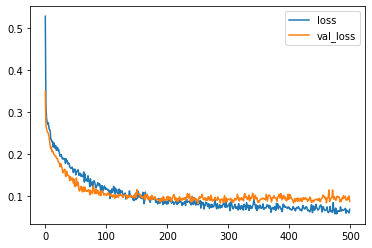

In [489]:
# Plot the loss across epochs
losses = pd.DataFrame(history.history)
losses[['loss','val_loss']].plot()

In [493]:
# Save model
model.save('iran_churn_model.h5')

### Evaluate the model's performance

#### This fitted model can actually serve as two different models: one cost insensitive and the other cost sensitive. Below I will compare the generalization/test set performances of these two models.

In [494]:
from sklearn.metrics import confusion_matrix, classification_report

In [495]:
def classification_report_confusion_matrix(y_pred, labels):
    """
    Function takes predictions and labels as input, 
    prints out a classification report,
    and returns a confusion matrix object.
    """
    print('\n')
    print(classification_report(labels, y_pred))
    return confusion_matrix(labels, y_pred)

In [496]:
def plot_confusion_matrices(cm_1, cm_2, labels=['Insensitive Model', 'Sensitive Model']):
    """
    Function takes two confusion matrices
    and their respective labels
    and plots them side by side.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

    sns.heatmap(cm_1, annot=True, ax = ax1, fmt='g', cmap='Blues');

    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels') 
    ax1.set_title(labels[0])
    ax1.xaxis.set_ticklabels(['No Churn (0)', 'Churn (1)'])   
    ax1.yaxis.set_ticklabels(['No Churn (0)', 'Churn (1)'])


    sns.heatmap(cm_2, annot=True, ax = ax2, fmt='g', cmap='Greens');

    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels') 
    ax2.set_title(labels[1])
    ax2.xaxis.set_ticklabels(['No Churn (0)', 'Churn (1)'])   
    ax2.yaxis.set_ticklabels(['No Churn (0)', 'Churn (1)'])
    
    plt.tight_layout()

### Test set performance
At the end of the day, we care about how this model generalizes to new, unseen data. Therefore, to keep the notebook clean I will only review the results on the test set, but these same metrics and plots could easily be calculated for the training and validation sets as well.

In [499]:
# Check the model's AUC score. This is the cost insensitive model.
print("AUC Score: ", model.evaluate(X_test_scaled, y_test)[2])

15/15 [==============================] - 0s 1ms/step - loss: 0.1149 - accuracy: 0.9662 - auc_2: 0.9876
AUC Score:  0.9876210689544678


In [500]:
# Compare the classification reports
print('COST INSENSITIVE MODEL')
y_pred_insensitive = model.predict_classes(X_test_scaled)
insensitive_cm = classification_report_confusion_matrix(y_pred_insensitive, y_test)
print('\n')
print("COST SENSITIVE MODEL")
y_pred_sensitive = expected_value_prediction(model, X_test_scaled, test_misclassification_cost_df)
sensitive_cm = classification_report_confusion_matrix(y_pred_sensitive, y_test)

COST INSENSITIVE MODEL


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       399
           1       0.88      0.91      0.89        74

    accuracy                           0.97       473
   macro avg       0.93      0.94      0.94       473
weighted avg       0.97      0.97      0.97       473



COST SENSITIVE MODEL


              precision    recall  f1-score   support

           0       0.94      0.99      0.96       399
           1       0.94      0.64      0.76        74

    accuracy                           0.94       473
   macro avg       0.94      0.81      0.86       473
weighted avg       0.94      0.94      0.93       473



While both models achieve fairly high accuracy, what immediately jumps out to me is how low the cost sensitive model's class 1 recall score is compared to that of the cost insensitive model. This means that the cost sensitive model detects a lower percentage of positive class instances (Churn instances) in the dataset than the cost insensitive model does. Furthermore, this indicates that the cost sensitive model was more worried about making false positive errors than false negative errors.

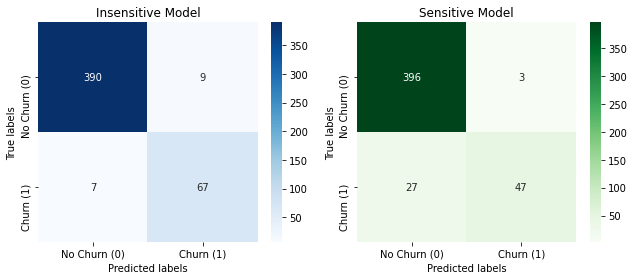

In [501]:
# Show side by side comparison of the confusion matrices
plot_confusion_matrices(insensitive_cm, sensitive_cm)

The confusion matrix above illustrates the cost sensitive model's preference for predicting the negative class, even if it leads to a greater number of misclassifications overall. In fact, the cost sensitive model misclassified more instances overall in what seems to be an effort to avoid making false positive errors in favor of false negatives.

#### Compare the total cost in dollars of each model's predictions

In [502]:
print("Insensitive Model Total cost: $", calculate_cost(y_test.tolist(), y_pred_insensitive, 
                                                        test_misclassification_cost_df))
print("Sensitive Model Total cost: $", calculate_cost(y_test.tolist(), y_pred_sensitive, 
                                                      test_misclassification_cost_df))

Insensitive Model Total cost: $ 1820.935
Sensitive Model Total cost: $ 1159.668


These results above explain why the cost sensitive model performs worse at the classification task: its objective is to minimize cost not misclassification error.

Although the cost sensitive model makes more misclassification errors overall, the model makes predictions that result in a lower overall cost. This highlights how the cost sensitive model is willing to misclassify many instances as long as it leads to predictions with a lower overall dollar cost in the end.

#### For the cost sensitive model, print the cost of the baseline strategy of random guessing and the cost savings

In [504]:
evaluate_cost_savings(model, test_misclassification_cost_df, X_test_scaled, y_test)
print('')

Random Guess Baseline Cost: $25802.35
Model Cost: $1159.67
Cost Savings: $24642.69





In [505]:
print('Proportion of baseline cost saved, Test set: ', 24642.69 / 25802.35)

Proportion of baseline cost saved, Test set:  0.9550560317180412


The true measure of a cost sensitive model is not accuracy or AUC score, but rather how much money it saves the business compared to an alternative strategy. If we assume the baseline alternative strategy is randomly guessing which customers will churn, then this cost sensitive model reduces costs by about 96%.

## Conclusion

I have built a neural network model that can predict whether a customer will churn with a high degree of accuracy. More importantly though, I have build a predictive model that optimizes a business's costs.

Although it minimizes costs, the cost sensitive model I built does misclassify more customers than the cost insensitive model. This is because a cost insensitive model assumes every misclassification is equally costly, so it's goal is to reduce misclassification as much as possible. On the other hand, a cost sensitive model can account for the fact that not all misclassifications are created equal by making cost-weighted predictions. The model I built developed a clear preference for making false negative errors rather than false positive errors. In other words, the model would rather miss flagging a customer that will actually churn than flag a customer that will not churn.

NOTE: The creators/maintainers of this dataset don't make it clear where the false positive and false negative cost values come from. Therefore, this analysis of the relative costs of false negatives and false positives assumes that the provided cost values are correct *without any further context*. Whether or not it makes sense for false postive churn errors to be more costly on average than false negative errors depends on context I cannot explain. Nevertheless, the procedure I performed will produce the optimal model given any set of false positive and false negative costs.

Finally, there are a few limitations worth mentioning. 

First, this model is not very explainable. The deep neural network model performs very well, but it is not clear what features it uses to determine if a customer will churn. If the purpose of this model is purely prediction and optimization, then this lack of interpretability is not very important. However, if the company wanted to use this model as a way to understand which variables were important for determining customer churn, then a more interpretable model, such as Gradient Boosting trees should be used.

Second, for my custom metric, I used "Cost Savings", which was defined as the dollar difference between a baseline cost and the cost sensitive model's cost. For the baseline cost, I assumed the company would randomly predict which customers would churn and calculated the cost based on these predictions. It's unlikely that a company would actually guess churn at random like this, but without any further context on the company's existing strategy, I chose this simple strategy as my baseline.

Overall this was a very enjoyable project. Although telecoms churn problems are not particularly interesting, the dataset's inclusion of misclassification costs was a novel challenge that forced me to develop clever strategies for building and optimizing a cost sensitive neural net model.